# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.

In [42]:
!jupyter nbconvert pt2.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

C:\Users\bvptr\anaconda3\envs\bsc\Lib\site-packages\traitlets\traitlets.py:2548: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'remove_cell' instead of "'remove_cell'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook pt2.ipynb to script
[NbConvertApp] Writing 31488 bytes to pt2.py


In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

## Generating the data

In [11]:
# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining some constants or parameters for convenience
c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

# Uncomment for pseudorandom data.
np.random.seed(0)

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau


# Defining a function that generates input data (conserved variables) from random samples of primitive variables
def generate_input_data(n_samples):
    """Generates input data (conserved variables) from random samples of primitive variables.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        torch.Tensor: The input data tensor of shape (n_samples, 3).
    """
    # Sampling the primitive variables using the sample_primitive_variables function
    rho, vx, epsilon = sample_primitive_variables(n_samples)

    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from random samples of primitive variables
def generate_labels(n_samples):
    """Generates output data (labels) from random samples of primitive variables.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        torch.Tensor: The output data tensor of shape (n_samples,).
    """
    # Sampling the primitive variables using the sample_primitive_variables function
    rho, _, epsilon = sample_primitive_variables(n_samples)

    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p


<Figure size 800x400 with 0 Axes>

<AxesSubplot:>

(array([16008., 10447.,  8413.,  6973.,  5797.,  5255.,  4566.,  3807.,
         3448.,  2976.,  2544.,  2202.,  1843.,  1586.,  1301.,  1045.,
          784.,   538.,   339.,   128.]),
 array([1.2271406e-05, 6.7581248e-01, 1.3516127e+00, 2.0274129e+00,
        2.7032132e+00, 3.3790135e+00, 4.0548139e+00, 4.7306137e+00,
        5.4064140e+00, 6.0822144e+00, 6.7580147e+00, 7.4338150e+00,
        8.1096153e+00, 8.7854156e+00, 9.4612160e+00, 1.0137015e+01,
        1.0812816e+01, 1.1488616e+01, 1.2164416e+01, 1.2840217e+01,
        1.3516017e+01], dtype=float32),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'y_train')

Text(0, 0.5, 'Frequency')

<AxesSubplot:>

(array([2035., 1215., 1028.,  837.,  693.,  683.,  570.,  504.,  461.,
         370.,  304.,  274.,  230.,  217.,  180.,  167.,  101.,   68.,
          43.,   20.]),
 array([1.02815415e-04, 6.66673183e-01, 1.33324361e+00, 1.99981403e+00,
        2.66638446e+00, 3.33295465e+00, 3.99952507e+00, 4.66609573e+00,
        5.33266592e+00, 5.99923611e+00, 6.66580677e+00, 7.33237696e+00,
        7.99894762e+00, 8.66551781e+00, 9.33208847e+00, 9.99865818e+00,
        1.06652288e+01, 1.13317995e+01, 1.19983702e+01, 1.26649399e+01,
        1.33315105e+01], dtype=float32),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'y_test')

Text(0, 0.5, 'Frequency')

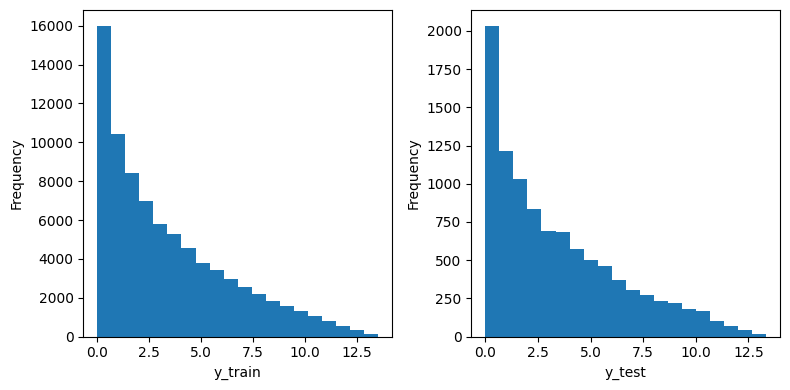

Shape of x_train: torch.Size([80000, 3])
Shape of y_train: torch.Size([80000])
Shape of x_test: torch.Size([10000, 3])
Shape of y_test: torch.Size([10000])


In [12]:

# Generating the input and output data for train and test sets using the functions defined
# Using the same number of samples as Dieseldorst et al.
x_train = generate_input_data(n_train_samples)
y_train = generate_labels(n_train_samples) 
x_test = generate_input_data(n_test_samples) 
y_test = generate_labels(n_test_samples) 

# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20)
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20)
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Checking the shapes of the data tensors
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

## Defining the neural network

In [5]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid # CHANGED: Added assertions and comments
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [6]:
# Defining a function to create a trial network and optimizer
def create_model(trial):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer.
    """

    # Sampling the hyperparameters from the search space
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = [trial.suggest_int(f"n_units_{i}", 16, 256) for i in range(n_layers)] 
    hidden_activation_name = trial.suggest_categorical(
        "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
    )
    output_activation_name = trial.suggest_categorical(
        "output_activation", ["Linear", "ReLU"]
    ) 
    loss_name = trial.suggest_categorical(
        "loss", ["MSE", "MAE", "Huber", "LogCosh"] 
    )
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
    )
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
    batch_size = trial.suggest_int("batch_size", 32, 256) #
    n_epochs = trial.suggest_int("n_epochs", 50, 100) 
    scheduler_name = trial.suggest_categorical(
        "scheduler",
        ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
    )

    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            """Computes the log-cosh loss between the predicted and true values.

            Args:
                y_pred (torch.Tensor): The predicted values tensor of shape (batch_size, 1).
                y_true (torch.Tensor): The true values tensor of shape (batch_size, 1).

            Returns:
                torch.Tensor: The log-cosh loss tensor of shape ().
            """
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=lr)
    else:
        # Added creating the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_name == "CosineAnnealingLR":
        # Added creating the CosineAnnealingLR scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif scheduler_name == "ReduceLROnPlateau":
        # Added creating the ReduceLROnPlateau scheduler
        # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
        )
    else:
        scheduler = None

    # Returning all variables needed for saving and loading # CHANGED: Added a return statement to return all variables
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation


 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [7]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [8]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [9]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation = create_model(trial)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [10]:
# Creating a study object with Optuna with TPE sampler and median pruner 
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

# Running Optuna with 100 trials without sampler and pruner arguments
study.optimize(objective, n_trials=100)

# Printing the best trial information
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-05-07 07:50:24,430] A new study created in memory with name: no-name-9f015af9-4ddb-4782-a6be-9401752b3bd8
/tmp/ipykernel_26905/2547659134.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) # CHANGED: Used a log-uniform distribution with a range of 1e-4 to 1e-2 for the learning rate


Epoch 1: Train Loss: 1.8061, Test Loss: 1.7699, Train L1 Norm: 16.5193, Test L1 Norm: 12.4400, Train Linf Norm: 825.3101, Test Linf Norm: 546.3081
Epoch 2: Train Loss: 1.7824, Test Loss: 1.7654, Train L1 Norm: 17.2991, Test L1 Norm: 11.9039, Train Linf Norm: 870.0799, Test Linf Norm: 523.0028
Epoch 3: Train Loss: 1.7810, Test Loss: 1.7668, Train L1 Norm: 17.3108, Test L1 Norm: 11.4184, Train Linf Norm: 888.4560, Test Linf Norm: 501.2407
Epoch 4: Train Loss: 1.7805, Test Loss: 1.7704, Train L1 Norm: 17.1827, Test L1 Norm: 11.2749, Train Linf Norm: 884.6797, Test Linf Norm: 493.7141
Epoch 5: Train Loss: 1.7800, Test Loss: 1.7660, Train L1 Norm: 17.1862, Test L1 Norm: 11.4963, Train Linf Norm: 891.6751, Test Linf Norm: 504.1000
Epoch 6: Train Loss: 1.7787, Test Loss: 1.7729, Train L1 Norm: 17.2076, Test L1 Norm: 10.8978, Train Linf Norm: 876.5932, Test Linf Norm: 476.7930
Epoch 7: Train Loss: 1.7790, Test Loss: 1.7653, Train L1 Norm: 17.3719, Test L1 Norm: 12.3621, Train Linf Norm: 895.74

[I 2023-05-07 07:54:41,940] Trial 0 finished with value: 11.850316779553891 and parameters: {'n_layers': 1, 'n_units_0': 156, 'hidden_activation': 'ELU', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'RMSprop', 'lr': 0.0003089908850240646, 'batch_size': 68, 'n_epochs': 64, 'scheduler': 'ExponentialLR'}. Best is trial 0 with value: 11.850316779553891.


Epoch 64: Train Loss: 1.7764, Test Loss: 1.7637, Train L1 Norm: 17.2160, Test L1 Norm: 11.8503, Train Linf Norm: 880.4566, Test Linf Norm: 519.1609
Epoch 1: Train Loss: 2.0393, Test Loss: 1.9363, Train L1 Norm: 12.2307, Test L1 Norm: 9.6840, Train Linf Norm: 1052.4683, Test Linf Norm: 732.8882
Epoch 2: Train Loss: 1.9435, Test Loss: 1.9116, Train L1 Norm: 13.9685, Test L1 Norm: 9.9680, Train Linf Norm: 1189.1559, Test Linf Norm: 749.0114
Epoch 3: Train Loss: 1.9232, Test Loss: 1.8933, Train L1 Norm: 14.2966, Test L1 Norm: 10.4427, Train Linf Norm: 1217.5653, Test Linf Norm: 782.7494
Epoch 4: Train Loss: 1.9067, Test Loss: 1.8783, Train L1 Norm: 14.3671, Test L1 Norm: 10.5289, Train Linf Norm: 1216.1462, Test Linf Norm: 787.3127
Epoch 5: Train Loss: 1.8923, Test Loss: 1.8660, Train L1 Norm: 14.4795, Test L1 Norm: 10.3329, Train Linf Norm: 1234.9336, Test Linf Norm: 770.0749
Epoch 6: Train Loss: 1.8798, Test Loss: 1.8539, Train L1 Norm: 14.7134, Test L1 Norm: 10.6431, Train Linf Norm: 12

[I 2023-05-07 07:59:31,260] Trial 1 finished with value: 10.853677866363526 and parameters: {'n_layers': 1, 'n_units_0': 157, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'SGD', 'lr': 0.0001670161972243837, 'batch_size': 122, 'n_epochs': 82, 'scheduler': 'StepLR'}. Best is trial 1 with value: 10.853677866363526.


Epoch 82: Train Loss: 1.8306, Test Loss: 1.8135, Train L1 Norm: 15.2936, Test L1 Norm: 10.8537, Train Linf Norm: 1300.5195, Test Linf Norm: 800.2321
Epoch 1: Train Loss: 2.9543, Test Loss: 2.9353, Train L1 Norm: 1.0001, Test L1 Norm: 0.9999, Train Linf Norm: 1.0562, Test Linf Norm: 1.0055
Epoch 2: Train Loss: 2.9543, Test Loss: 2.9353, Train L1 Norm: 1.0001, Test L1 Norm: 0.9999, Train Linf Norm: 1.0756, Test Linf Norm: 1.0120
Epoch 3: Train Loss: 2.9542, Test Loss: 2.9353, Train L1 Norm: 1.0002, Test L1 Norm: 0.9999, Train Linf Norm: 1.0889, Test Linf Norm: 1.0191
Epoch 4: Train Loss: 2.9542, Test Loss: 2.9353, Train L1 Norm: 1.0002, Test L1 Norm: 0.9998, Train Linf Norm: 1.1034, Test Linf Norm: 1.0271
Epoch 5: Train Loss: 2.9542, Test Loss: 2.9353, Train L1 Norm: 1.0002, Test L1 Norm: 0.9998, Train Linf Norm: 1.1224, Test Linf Norm: 1.0362
Epoch 6: Train Loss: 2.9542, Test Loss: 2.9352, Train L1 Norm: 1.0002, Test L1 Norm: 0.9998, Train Linf Norm: 1.1395, Test Linf Norm: 1.0467
Epoch

[I 2023-05-07 08:02:08,733] Trial 2 finished with value: 0.9989154116511345 and parameters: {'n_layers': 2, 'n_units_0': 79, 'n_units_1': 193, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.0001304170374026519, 'batch_size': 233, 'n_epochs': 56, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 2 with value: 0.9989154116511345.


Epoch 56: Train Loss: 2.9528, Test Loss: 2.9338, Train L1 Norm: 1.0024, Test L1 Norm: 0.9989, Train Linf Norm: 2.1741, Test Linf Norm: 1.5179
Epoch 1: Train Loss: 1.8247, Test Loss: 1.7788, Train L1 Norm: 15.0653, Test L1 Norm: 11.3699, Train Linf Norm: 2174.9655, Test Linf Norm: 1213.4413
Epoch 2: Train Loss: 1.7908, Test Loss: 1.7721, Train L1 Norm: 17.0295, Test L1 Norm: 11.6029, Train Linf Norm: 2494.1654, Test Linf Norm: 1241.0643
Epoch 3: Train Loss: 1.7857, Test Loss: 1.7694, Train L1 Norm: 17.1367, Test L1 Norm: 11.5968, Train Linf Norm: 2418.3921, Test Linf Norm: 1241.9817
Epoch 4: Train Loss: 1.7833, Test Loss: 1.7680, Train L1 Norm: 17.1605, Test L1 Norm: 11.6540, Train Linf Norm: 2328.2037, Test Linf Norm: 1249.0601
Epoch 5: Train Loss: 1.7821, Test Loss: 1.7672, Train L1 Norm: 17.2095, Test L1 Norm: 11.6698, Train Linf Norm: 2492.8787, Test Linf Norm: 1252.0308
Epoch 6: Train Loss: 1.7813, Test Loss: 1.7667, Train L1 Norm: 17.2070, Test L1 Norm: 11.7836, Train Linf Norm: 2

[W 2023-05-07 08:05:10,382] Trial 3 failed with parameters: {'n_layers': 2, 'n_units_0': 104, 'n_units_1': 88, 'hidden_activation': 'Tanh', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0007878983783182211, 'batch_size': 225, 'n_epochs': 89, 'scheduler': 'ReduceLROnPlateau'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/yousousen/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26905/4122804367.py", line 27, in objective
    _, _, _, test_metrics = train_and_eval(
  File "/tmp/ipykernel_26905/3615620923.py", line 109, in train_and_eval
    y_pred = net(x_batch)
  File "/home/yousousen/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_26905/609318184.py", line 53, in forward
    x = self.hidden_activ

KeyboardInterrupt: 

## Training with the best hyperparameters

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
net, \
loss_fn, \
optimizer, \
batch_size, \
n_epochs, \
scheduler, \
loss_name, \
optimizer_name, \
scheduler_name, \
n_units, \
n_layers, \
hidden_activation, \
output_activation = create_model(trial)



# Training and evaluating the best network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="MSE of training data")
plt.plot(test_losses,label="MSE of test data")
if scheduler is not None:
    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Saving

In [ ]:
import pickle
import pandas as pd

# Saving the best network state dictionary using torch.save
torch.save(net.state_dict(), "best_net.pth")

# Saving the loss function name using pickle
with open("loss_fn.pkl", "wb") as f:
    pickle.dump(loss_name, f)

# Saving the optimizer name and parameters using pickle
with open("optimizer.pkl", "wb") as f:
    pickle.dump((optimizer_name, optimizer.state_dict()), f)

# Saving the best number of epochs using pickle
with open("n_epochs.pkl", "wb") as f:
    pickle.dump(n_epochs, f)

# Saving the scheduler name and parameters using pickle
with open("scheduler.pkl", "wb") as f:
    pickle.dump((scheduler_name, scheduler.state_dict()), f)

# Saving the number of units for each hidden layer using pickle
with open("n_units.pkl", "wb") as f:
    pickle.dump(n_units, f)

# Saving the output of create_model using pickle
with open("create_model.pkl", "wb") as f:
    pickle.dump((net, loss_fn, optimizer, batch_size, n_epochs, scheduler), f)

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)

## Loading

In [ ]:
## Loading the best network state dictionary using torch.load
state_dict = torch.load("best_net.pth")

# Loading the state dictionary into a new network instance using net.load_state_dict
new_net = Net(n_layers, n_units, hidden_activation, output_activation).to(device)
new_net.load_state_dict(state_dict)


# In[ ]:


# Loading the loss function name using pickle
with open("loss_fn.pkl", "rb") as f:
    loss_name = pickle.load(f)

# Loading the optimizer name and parameters using pickle
with open("optimizer.pkl", "rb") as f:
    optimizer_name, optimizer_state_dict = pickle.load(f)

# Loading the best number of epochs using pickle
with open("n_epochs.pkl", "rb") as f:
    n_epochs = pickle.load(f)

# Loading the scheduler name and parameters using pickle
with open("scheduler.pkl", "rb") as f:
    scheduler_name, scheduler_state_dict = pickle.load(f)

# Loading the number of units for each hidden layer using pickle
with open("n_units.pkl", "rb") as f:
    n_units = pickle.load(f)

# Loading the output of create_model using pickle
with open("create_model.pkl", "rb") as f:
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler = pickle.load(f)

# Loading the output of the training using pandas
train_df = pd.read_csv("train_output.csv")
train_losses = train_df["train_loss"].tolist()
test_losses = train_df["test_loss"].tolist()
train_metrics = [
    {
        "l1_norm": train_df["train_l1_norm"][i],
        "linf_norm": train_df["train_linf_norm"][i],
    }
    for i in range(len(train_df))
]
test_metrics = [
    {
        "l1_norm": train_df["test_l1_norm"][i],
        "linf_norm": train_df["test_linf_norm"][i],
    }
    for i in range(len(train_df))
]